# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

2050647


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")


- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF4_4T1Primary16bit')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
# The output codebook filename
#codebook_file = os.path.join(library_folder, 'codebook.csv') # not used in this jupyter
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
#readout_savefile = os.path.join(library_folder, 'readouts.csv') # not used in this jupyter

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [6]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


In [7]:
mRNA_fasta_file

'/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa'

## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [9]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = cdna#pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: user 2.39 s, sys: 399 ms, total: 2.79 s
Wall time: 2.81 s


In [10]:
print(mRNA_fasta_file)

/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa


# Load gene-selection

In [11]:
# save
print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename)
target_gene_mean_exp_df = target_gene_mean_exp_df.set_index(target_gene_mean_exp_df.columns[0])

Loading mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/marker_gene_mean_exp.csv


## Loading ends here

# Design targeting sequences

In [12]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000060586.12', 'gene_short_name'] = 'H2-Eb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000073421.7', 'gene_short_name'] = 'H2-Ab1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000036594.16', 'gene_short_name'] = 'H2-Aa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000041538.17', 'gene_short_name'] = 'H2-Ob'


# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki',
                'Hist1h1b':'H1f5','Fam129b':'Niban2','Sept3':'Septin3',
                'Hist1h2ab':'H2ac4',
                'Il1f9':'Il36g','Cd163l1':'Scart1','Hist1h2af':'H2ac10',
                'Fam71f2':'Garin1a','Hist1h3c':'H3c3','Ero1l':'Ero1a','Fam129c':'Niban3',
                'Gm14548':'Pira12','Ptprg':'PTPRG',
               }
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))
    break

In [13]:
gene_ids = target_gene_mean_exp_df.index.values

In [14]:
len(gene_ids)

150

In [15]:
np.save(os.path.join(library_folder, 'replace_dict.npy'), replace_dict, allow_pickle=True)

In [16]:
transcriptome.loc[transcriptome['transcript_id']=='ENSMUST00000225720.2']

,transcript_id,sequence,FPKM,gene_id,gene_short_name
54749,ENSMUST00000225720.2,CCCATACCAAATCTCTGGGAGACTTTCTGGCTGCCCATGAGTAACT...,1,ENSMUSG00000037798.8,Mat1a


In [17]:
transcriptome.loc[transcriptome['transcript_id']=='ENSMUST00000047286.7']

,transcript_id,sequence,FPKM,gene_id,gene_short_name
54751,ENSMUST00000047286.7,GTGACACATCTGTATTCCATCCGCTATCTCCCTCTTTGCCCATCCT...,1,ENSMUSG00000037798.8,Mat1a


In [18]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
#if len(transcript_ids) == len(gene_ids):
#    # Select the transcripts that we want to target
#    # The target transcripts are already defined in the codebook
#    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 600 transcripts for 150 target genes.
Gene	Transcript	N_probes
Trbc2
	ENSMUST00000103299.3	663
Trdc
	ENSMUST00000196323.2	3836
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Iglc2
	ENSMUST00000198182.2	429
	ENSMUST00000103749.3	577
Klhl14
	ENSMUST00000122333.2	4394
	ENSMUST00000049105.11	3989
Tmem252
	ENSMUST00000057243.6	5005
Dab2
	ENSMUST00000159552.2	613
	ENSMUST00000078019.13	3764
	ENSMUST00000159046.2	339
	ENSMUST00000161040.8	1069
	ENSMUST00000162140.2	1377
	ENSMUST00000080880.12	4634
	ENSMUST00000110663.9	2725
	ENSMUST00000161812.8	2681
	ENSMUST00000160134.8	1345
	ENSMUST00000159490.8	364
	ENSMUST00000162094.3	708
	ENSMUST00000163082.2	2005
	ENSMUST00000161558.2	447
	ENSMUST00000110664.9	4421
Camk4
	ENSMUST00000234205.2	1839
	ENSMUST00000234654.2	1800
	ENSMUST00000234001.2	497
	ENSMUST00000042868.6	2688
Themis
	ENSMUST00000060409.13	2249
	ENSMUST00000056097.11	5053
	ENSMUST00000162343.2	3374
	ENSMUST000001

## Based on gff3 reference, keep only the protein-coding isoforms:

In [19]:
# For the selected gene_ids, laod gff3
from ChromAn.src.sequence_tools.reference_io import gff3_reader
gff3_ref = gff3_reader(gff3_file, save=True, save_filename=os.path.join(library_folder, 'gff3_info.pkl'),
                       auto_read=True)

- loading from save_file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/gff3_info.pkl
parsing all gene information
gene:ENSMUSG00000102693
gene:ENSMUSG00000064842
gene:ENSMUSG00000051951
gene:ENSMUSG00000102851
gene:ENSMUSG00000103377
gene:ENSMUSG00000104017
gene:ENSMUSG00000103025
gene:ENSMUSG00000089699
gene:ENSMUSG00000103201
gene:ENSMUSG00000103147
gene:ENSMUSG00000103161
gene:ENSMUSG00000102331
gene:ENSMUSG00000102348
gene:ENSMUSG00000102592
gene:ENSMUSG00000088333
gene:ENSMUSG00000102343
gene:ENSMUSG00000025900
gene:ENSMUSG00000102948
gene:ENSMUSG00000104123
gene:ENSMUSG00000025902
gene:ENSMUSG00000104238
gene:ENSMUSG00000102269
gene:ENSMUSG00000118917
gene:ENSMUSG00000103003
gene:ENSMUSG00000104328
gene:ENSMUSG00000102735
gene:ENSMUSG00000098104
gene:ENSMUSG00000102175
gene:ENSMUSG00002075947
gene:ENSMUSG00000103265
gene:ENSMUSG00000103922
gene:ENSMUSG00000033845
gene:ENSMUSG00000102275
gene:ENSMUSG00000120403
gene:ENSMUSG00000025903
gene:ENSMUSG000

gene:ENSMUSG00000064440
gene:ENSMUSG00000080463
gene:ENSMUSG00000064816
gene:ENSMUSG00000084667
gene:ENSMUSG00000077220
gene:ENSMUSG00000065160
gene:ENSMUSG00000065735
gene:ENSMUSG00002075950
gene:ENSMUSG00000064968
gene:ENSMUSG00000065228
gene:ENSMUSG00000026709
gene:ENSMUSG00000102864
gene:ENSMUSG00000026708
gene:ENSMUSG00000026705
gene:ENSMUSG00000044835
gene:ENSMUSG00000049160
gene:ENSMUSG00000102817
gene:ENSMUSG00000121369
gene:ENSMUSG00000026701
gene:ENSMUSG00000104163
gene:ENSMUSG00000026700
gene:ENSMUSG00000066755
gene:ENSMUSG00002076072
gene:ENSMUSG00000102860
gene:ENSMUSG00000040323
gene:ENSMUSG00000102399
gene:ENSMUSG00000000817
gene:ENSMUSG00000103625
gene:ENSMUSG00000040297
gene:ENSMUSG00000102254
gene:ENSMUSG00000120750
gene:ENSMUSG00000103158
gene:ENSMUSG00000086277
gene:ENSMUSG00000026698
gene:ENSMUSG00000103393
gene:ENSMUSG00000040265
gene:ENSMUSG00000090260
gene:ENSMUSG00000102994
gene:ENSMUSG00000078190
gene:ENSMUSG00000070126
gene:ENSMUSG00000065516
gene:ENSMUSG0000

gene:ENSMUSG00000069824
gene:ENSMUSG00000108577
gene:ENSMUSG00000069823
gene:ENSMUSG00000121512
gene:ENSMUSG00000086278
gene:ENSMUSG00000108673
gene:ENSMUSG00000055971
gene:ENSMUSG00000084387
gene:ENSMUSG00000072709
gene:ENSMUSG00000108742
gene:ENSMUSG00000072708
gene:ENSMUSG00000095312
gene:ENSMUSG00000081961
gene:ENSMUSG00000095095
gene:ENSMUSG00000060335
gene:ENSMUSG00000082338
gene:ENSMUSG00000061246
gene:ENSMUSG00000060630
gene:ENSMUSG00000108598
gene:ENSMUSG00000080781
gene:ENSMUSG00000088811
gene:ENSMUSG00000081552
gene:ENSMUSG00000070383
gene:ENSMUSG00000069818
gene:ENSMUSG00000070382
gene:ENSMUSG00000061984
gene:ENSMUSG00000081698
gene:ENSMUSG00000094488
gene:ENSMUSG00000108735
gene:ENSMUSG00000056921
gene:ENSMUSG00000108707
gene:ENSMUSG00000062186
gene:ENSMUSG00000108605
gene:ENSMUSG00000069816
gene:ENSMUSG00000079875
gene:ENSMUSG00000057050
gene:ENSMUSG00000049041
gene:ENSMUSG00000047444
gene:ENSMUSG00000043692
gene:ENSMUSG00000069476
gene:ENSMUSG00000081932
gene:ENSMUSG0000

gene:ENSMUSG00000113679
gene:ENSMUSG00000033530
gene:ENSMUSG00000113917
gene:ENSMUSG00000113864
gene:ENSMUSG00000113895
gene:ENSMUSG00000021180
gene:ENSMUSG00000113687
gene:ENSMUSG00000113195
gene:ENSMUSG00000113250
gene:ENSMUSG00000113113
gene:ENSMUSG00000064572
gene:ENSMUSG00000021185
gene:ENSMUSG00000120898
gene:ENSMUSG00000113159
gene:ENSMUSG00000082604
gene:ENSMUSG00000047415
gene:ENSMUSG00000118530
gene:ENSMUSG00000021182
gene:ENSMUSG00000097160
gene:ENSMUSG00000113634
gene:ENSMUSG00000080575
gene:ENSMUSG00000114113
gene:ENSMUSG00000041846
gene:ENSMUSG00000097121
gene:ENSMUSG00000121355
gene:ENSMUSG00000113817
gene:ENSMUSG00000092054
gene:ENSMUSG00000098167
gene:ENSMUSG00000113134
gene:ENSMUSG00000113178
gene:ENSMUSG00000119861
gene:ENSMUSG00000121356
gene:ENSMUSG00000047014
gene:ENSMUSG00002075596
gene:ENSMUSG00000021187
gene:ENSMUSG00000090152
gene:ENSMUSG00000021186
gene:ENSMUSG00000021188
gene:ENSMUSG00000093758
gene:ENSMUSG00000093437
gene:ENSMUSG00000093579
gene:ENSMUSG0000

gene:ENSMUSG00000095493
gene:ENSMUSG00000047441
gene:ENSMUSG00000115489
gene:ENSMUSG00000021950
gene:ENSMUSG00000088533
gene:ENSMUSG00000115180
gene:ENSMUSG00000115101
gene:ENSMUSG00000048337
gene:ENSMUSG00000078126
gene:ENSMUSG00000115673
gene:ENSMUSG00000071531
gene:ENSMUSG00000115299
gene:ENSMUSG00000041479
gene:ENSMUSG00000115124
gene:ENSMUSG00000041471
gene:ENSMUSG00000115649
gene:ENSMUSG00000115183
gene:ENSMUSG00000115214
gene:ENSMUSG00000021794
gene:ENSMUSG00000115431
gene:ENSMUSG00000043681
gene:ENSMUSG00000023064
gene:ENSMUSG00000041445
gene:ENSMUSG00000021796
gene:ENSMUSG00000090779
gene:ENSMUSG00000021797
gene:ENSMUSG00000115582
gene:ENSMUSG00000021798
gene:ENSMUSG00000021799
gene:ENSMUSG00000115509
gene:ENSMUSG00000120050
gene:ENSMUSG00000115575
gene:ENSMUSG00000115451
gene:ENSMUSG00000115007
gene:ENSMUSG00000041408
gene:ENSMUSG00000097310
gene:ENSMUSG00000115109
gene:ENSMUSG00000120637
gene:ENSMUSG00000041078
gene:ENSMUSG00000065481
gene:ENSMUSG00000115826
gene:ENSMUSG0000

gene:ENSMUSG00000023039
gene:ENSMUSG00000047641
gene:ENSMUSG00000063971
gene:ENSMUSG00000067615
gene:ENSMUSG00000067614
gene:ENSMUSG00000116011
gene:ENSMUSG00000067613
gene:ENSMUSG00000116107
gene:ENSMUSG00000116188
gene:ENSMUSG00000116336
gene:ENSMUSG00000044294
gene:ENSMUSG00000049548
gene:ENSMUSG00000048699
gene:ENSMUSG00002075773
gene:ENSMUSG00000022986
gene:ENSMUSG00002076745
gene:ENSMUSG00000115983
gene:ENSMUSG00000116129
gene:ENSMUSG00000121433
gene:ENSMUSG00000115860
gene:ENSMUSG00000064232
gene:ENSMUSG00000115903
gene:ENSMUSG00000095241
gene:ENSMUSG00002075440
gene:ENSMUSG00000118545
gene:ENSMUSG00000023041
gene:ENSMUSG00002075844
gene:ENSMUSG00000058354
gene:ENSMUSG00000116132
gene:ENSMUSG00002075978
gene:ENSMUSG00000061527
gene:ENSMUSG00002076431
gene:ENSMUSG00000051879
gene:ENSMUSG00000067596
gene:ENSMUSG00000056605
gene:ENSMUSG00000063661
gene:ENSMUSG00000064201
gene:ENSMUSG00000046834
gene:ENSMUSG00000067594
gene:ENSMUSG00000075402
gene:ENSMUSG00002076101
gene:ENSMUSG0000

gene:ENSMUSG00000116999
gene:ENSMUSG00000120961
gene:ENSMUSG00000116826
gene:ENSMUSG00000035270
gene:ENSMUSG00000116998
gene:ENSMUSG00000035258
gene:ENSMUSG00000022757
gene:ENSMUSG00000022755
gene:ENSMUSG00000082485
gene:ENSMUSG00000022754
gene:ENSMUSG00000084999
gene:ENSMUSG00000083467
gene:ENSMUSG00000109588
gene:ENSMUSG00000116866
gene:ENSMUSG00000046748
gene:ENSMUSG00000022752
gene:ENSMUSG00000022751
gene:ENSMUSG00000097876
gene:ENSMUSG00000022749
gene:ENSMUSG00000116675
gene:ENSMUSG00000022753
gene:ENSMUSG00000097896
gene:ENSMUSG00000022748
gene:ENSMUSG00000116877
gene:ENSMUSG00000116789
gene:ENSMUSG00000043336
gene:ENSMUSG00000068196
gene:ENSMUSG00000116873
gene:ENSMUSG00000116788
gene:ENSMUSG00000116920
gene:ENSMUSG00000119068
gene:ENSMUSG00000116630
gene:ENSMUSG00000104285
gene:ENSMUSG00000116770
gene:ENSMUSG00000116717
gene:ENSMUSG00000104456
gene:ENSMUSG00000086827
gene:ENSMUSG00000035107
gene:ENSMUSG00000022747
gene:ENSMUSG00000116914
gene:ENSMUSG00000075002
gene:ENSMUSG0000

gene:ENSMUSG00000117345
gene:ENSMUSG00000117419
gene:ENSMUSG00000091785
gene:ENSMUSG00000088126
gene:ENSMUSG00000055771
gene:ENSMUSG00000117526
gene:ENSMUSG00000057455
gene:ENSMUSG00000117502
gene:ENSMUSG00002075774
gene:ENSMUSG00000024261
gene:ENSMUSG00000096934
gene:ENSMUSG00000077169
gene:ENSMUSG00000117576
gene:ENSMUSG00000024259
gene:ENSMUSG00000092124
gene:ENSMUSG00000024260
gene:ENSMUSG00000117533
gene:ENSMUSG00000041915
gene:ENSMUSG00000097748
gene:ENSMUSG00000024258
gene:ENSMUSG00000024400
gene:ENSMUSG00000091561
gene:ENSMUSG00000044982
gene:ENSMUSG00000024395
gene:ENSMUSG00000052229
gene:ENSMUSG00000024388
gene:ENSMUSG00000084824
gene:ENSMUSG00000085300
gene:ENSMUSG00000120022
gene:ENSMUSG00000024384
gene:ENSMUSG00000117481
gene:ENSMUSG00000117650
gene:ENSMUSG00000024386
gene:ENSMUSG00000117606
gene:ENSMUSG00000097363
gene:ENSMUSG00000024383
gene:ENSMUSG00000024382
gene:ENSMUSG00002075437
gene:ENSMUSG00000097413
gene:ENSMUSG00000024381
gene:ENSMUSG00000109238
gene:ENSMUSG0000

gene:ENSMUSG00000085742
gene:ENSMUSG00000026788
gene:ENSMUSG00000086939
gene:ENSMUSG00000038765
gene:ENSMUSG00000104403
gene:ENSMUSG00000052951
gene:ENSMUSG00000081244
gene:ENSMUSG00000085463
gene:ENSMUSG00000038740
gene:ENSMUSG00000086484
gene:ENSMUSG00002075431
gene:ENSMUSG00000121186
gene:ENSMUSG00000085987
gene:ENSMUSG00000086904
gene:ENSMUSG00000087461
gene:ENSMUSG00000103413
gene:ENSMUSG00000038718
gene:ENSMUSG00000084908
gene:ENSMUSG00000038696
gene:ENSMUSG00000083503
gene:ENSMUSG00000083233
gene:ENSMUSG00000081992
gene:ENSMUSG00000087635
gene:ENSMUSG00000026867
gene:ENSMUSG00000121211
gene:ENSMUSG00000026864
gene:ENSMUSG00000070953
gene:ENSMUSG00000120298
gene:ENSMUSG00000035949
gene:ENSMUSG00000081904
gene:ENSMUSG00000107167
gene:ENSMUSG00000026869
gene:ENSMUSG00000121258
gene:ENSMUSG00000026870
gene:ENSMUSG00000026873
gene:ENSMUSG00000086001
gene:ENSMUSG00000088754
gene:ENSMUSG00000026875
gene:ENSMUSG00000121265
gene:ENSMUSG00000083533
gene:ENSMUSG00000026874
gene:ENSMUSG0000

gene:ENSMUSG00000103461
gene:ENSMUSG00000103116
gene:ENSMUSG00000103011
gene:ENSMUSG00000069114
gene:ENSMUSG00002076460
gene:ENSMUSG00000097365
gene:ENSMUSG00000040209
gene:ENSMUSG00000103485
gene:ENSMUSG00000120589
gene:ENSMUSG00000103876
gene:ENSMUSG00000027508
gene:ENSMUSG00000089794
gene:ENSMUSG00002076636
gene:ENSMUSG00000120107
gene:ENSMUSG00000102795
gene:ENSMUSG00000103698
gene:ENSMUSG00000027533
gene:ENSMUSG00000104000
gene:ENSMUSG00000049230
gene:ENSMUSG00000103045
gene:ENSMUSG00000052468
gene:ENSMUSG00000103124
gene:ENSMUSG00000027528
gene:ENSMUSG00000062515
gene:ENSMUSG00000102705
gene:ENSMUSG00000104434
gene:ENSMUSG00000102834
gene:ENSMUSG00000027530
gene:ENSMUSG00000104092
gene:ENSMUSG00000103592
gene:ENSMUSG00000027531
gene:ENSMUSG00000103392
gene:ENSMUSG00000058921
gene:ENSMUSG00000039795
gene:ENSMUSG00000121077
gene:ENSMUSG00000027536
gene:ENSMUSG00000027534
gene:ENSMUSG00000104451
gene:ENSMUSG00000104185
gene:ENSMUSG00000102470
gene:ENSMUSG00000087858
gene:ENSMUSG0000

gene:ENSMUSG00000077607
gene:ENSMUSG00000081391
gene:ENSMUSG00000083385
gene:ENSMUSG00000087540
gene:ENSMUSG00002076931
gene:ENSMUSG00000087608
gene:ENSMUSG00000087110
gene:ENSMUSG00002075489
gene:ENSMUSG00000085022
gene:ENSMUSG00000008575
gene:ENSMUSG00002075784
gene:ENSMUSG00000120940
gene:ENSMUSG00000087413
gene:ENSMUSG00000084851
gene:ENSMUSG00000084357
gene:ENSMUSG00000086293
gene:ENSMUSG00000028403
gene:ENSMUSG00000038192
gene:ENSMUSG00000059049
gene:ENSMUSG00000089409
gene:ENSMUSG00000082637
gene:ENSMUSG00000083245
gene:ENSMUSG00000038172
gene:ENSMUSG00000119168
gene:ENSMUSG00000086321
gene:ENSMUSG00000087592
gene:ENSMUSG00000028483
gene:ENSMUSG00000028484
gene:ENSMUSG00000082416
gene:ENSMUSG00000066116
gene:ENSMUSG00000120694
gene:ENSMUSG00000052407
gene:ENSMUSG00000064606
gene:ENSMUSG00000098217
gene:ENSMUSG00000080793
gene:ENSMUSG00000097942
gene:ENSMUSG00000085378
gene:ENSMUSG00000085217
gene:ENSMUSG00000083044
gene:ENSMUSG00000087378
gene:ENSMUSG00000028487
gene:ENSMUSG0000

gene:ENSMUSG00000055961
gene:ENSMUSG00000007457
gene:ENSMUSG00000100704
gene:ENSMUSG00000007907
gene:ENSMUSG00000029280
gene:ENSMUSG00000105905
gene:ENSMUSG00000104640
gene:ENSMUSG00000029281
gene:ENSMUSG00000079439
gene:ENSMUSG00000105807
gene:ENSMUSG00000079438
gene:ENSMUSG00000106065
gene:ENSMUSG00000105576
gene:ENSMUSG00000106593
gene:ENSMUSG00000090302
gene:ENSMUSG00000064156
gene:ENSMUSG00000029282
gene:ENSMUSG00000106633
gene:ENSMUSG00000105013
gene:ENSMUSG00000029288
gene:ENSMUSG00000029286
gene:ENSMUSG00000067149
gene:ENSMUSG00000106322
gene:ENSMUSG00000070697
gene:ENSMUSG00000120316
gene:ENSMUSG00000029291
gene:ENSMUSG00000044221
gene:ENSMUSG00000121172
gene:ENSMUSG00000006262
gene:ENSMUSG00000095524
gene:ENSMUSG00000029366
gene:ENSMUSG00000105640
gene:ENSMUSG00000106305
gene:ENSMUSG00000082389
gene:ENSMUSG00000060961
gene:ENSMUSG00000121166
gene:ENSMUSG00000035540
gene:ENSMUSG00000106534
gene:ENSMUSG00000104715
gene:ENSMUSG00000035528
gene:ENSMUSG00000043635
gene:ENSMUSG0000

gene:ENSMUSG00000108195
gene:ENSMUSG00000107436
gene:ENSMUSG00000107865
gene:ENSMUSG00000108006
gene:ENSMUSG00002074885
gene:ENSMUSG00000107780
gene:ENSMUSG00000108143
gene:ENSMUSG00000030050
gene:ENSMUSG00000030049
gene:ENSMUSG00000030048
gene:ENSMUSG00000030046
gene:ENSMUSG00000030047
gene:ENSMUSG00000108184
gene:ENSMUSG00000049409
gene:ENSMUSG00000108118
gene:ENSMUSG00000030051
gene:ENSMUSG00000107593
gene:ENSMUSG00000071332
gene:ENSMUSG00000121511
gene:ENSMUSG00000089997
gene:ENSMUSG00000108079
gene:ENSMUSG00000068263
gene:ENSMUSG00000068262
gene:ENSMUSG00000107849
gene:ENSMUSG00000030054
gene:ENSMUSG00000030055
gene:ENSMUSG00000107928
gene:ENSMUSG00000108064
gene:ENSMUSG00000108120
gene:ENSMUSG00000030056
gene:ENSMUSG00000108042
gene:ENSMUSG00000030057
gene:ENSMUSG00000107798
gene:ENSMUSG00000030058
gene:ENSMUSG00000097763
gene:ENSMUSG00000030060
gene:ENSMUSG00000068689
gene:ENSMUSG00000044927
gene:ENSMUSG00000084950
gene:ENSMUSG00002076518
gene:ENSMUSG00000108049
gene:ENSMUSG0000

gene:ENSMUSG00002076324
gene:ENSMUSG00002075860
gene:ENSMUSG00000119499
gene:ENSMUSG00002076260
gene:ENSMUSG00000077869
gene:ENSMUSG00000119021
gene:ENSMUSG00000119456
gene:ENSMUSG00002075559
gene:ENSMUSG00000092921
gene:ENSMUSG00000077107
gene:ENSMUSG00000065568
gene:ENSMUSG00000109465
gene:ENSMUSG00000109321
gene:ENSMUSG00000109178
gene:ENSMUSG00000093187
gene:ENSMUSG00000092850
gene:ENSMUSG00000077194
gene:ENSMUSG00000093108
gene:ENSMUSG00002076274
gene:ENSMUSG00000119672
gene:ENSMUSG00000045813
gene:ENSMUSG00000108986
gene:ENSMUSG00000033585
gene:ENSMUSG00000056972
gene:ENSMUSG00000070527
gene:ENSMUSG00000070526
gene:ENSMUSG00000072460
gene:ENSMUSG00000108928
gene:ENSMUSG00000077683
gene:ENSMUSG00000109204
gene:ENSMUSG00000109289
gene:ENSMUSG00000109344
gene:ENSMUSG00000030525
gene:ENSMUSG00000109057
gene:ENSMUSG00000097682
gene:ENSMUSG00000033510
gene:ENSMUSG00000081788
gene:ENSMUSG00002074869
gene:ENSMUSG00000093751
gene:ENSMUSG00000108421
gene:ENSMUSG00000108700
gene:ENSMUSG0000

gene:ENSMUSG00000003573
gene:ENSMUSG00000057788
gene:ENSMUSG00000055681
gene:ENSMUSG00000087408
gene:ENSMUSG00000109523
gene:ENSMUSG00000058301
gene:ENSMUSG00000031849
gene:ENSMUSG00000003575
gene:ENSMUSG00000055707
gene:ENSMUSG00000035964
gene:ENSMUSG00000110052
gene:ENSMUSG00000007888
gene:ENSMUSG00000058833
gene:ENSMUSG00000090137
gene:ENSMUSG00000055553
gene:ENSMUSG00000121178
gene:ENSMUSG00000019428
gene:ENSMUSG00000070002
gene:ENSMUSG00000019139
gene:ENSMUSG00000070003
gene:ENSMUSG00000110030
gene:ENSMUSG00000049988
gene:ENSMUSG00000038508
gene:ENSMUSG00000056204
gene:ENSMUSG00000031848
gene:ENSMUSG00000071076
gene:ENSMUSG00000080058
gene:ENSMUSG00000110622
gene:ENSMUSG00000095026
gene:ENSMUSG00000031842
gene:ENSMUSG00000031840
gene:ENSMUSG00000035559
gene:ENSMUSG00000031838
gene:ENSMUSG00000110575
gene:ENSMUSG00000031834
gene:ENSMUSG00000100691
gene:ENSMUSG00000031833
gene:ENSMUSG00000099031
gene:ENSMUSG00000000791
gene:ENSMUSG00000002910
gene:ENSMUSG00000002908
gene:ENSMUSG0000

gene:ENSMUSG00000120943
gene:ENSMUSG00000104041
gene:ENSMUSG00000065107
gene:ENSMUSG00000101648
gene:ENSMUSG00000102963
gene:ENSMUSG00000102702
gene:ENSMUSG00000098521
gene:ENSMUSG00002075265
gene:ENSMUSG00000111859
gene:ENSMUSG00000035606
gene:ENSMUSG00002075918
gene:ENSMUSG00000101563
gene:ENSMUSG00000102126
gene:ENSMUSG00000100279
gene:ENSMUSG00000110739
gene:ENSMUSG00000032534
gene:ENSMUSG00000035048
gene:ENSMUSG00000099491
gene:ENSMUSG00000102200
gene:ENSMUSG00000032531
gene:ENSMUSG00000093812
gene:ENSMUSG00000102204
gene:ENSMUSG00000110884
gene:ENSMUSG00000111395
gene:ENSMUSG00000032547
gene:ENSMUSG00000110877
gene:ENSMUSG00000032548
gene:ENSMUSG00002076769
gene:ENSMUSG00002075362
gene:ENSMUSG00000077438
gene:ENSMUSG00000110765
gene:ENSMUSG00000032549
gene:ENSMUSG00000102461
gene:ENSMUSG00000032553
gene:ENSMUSG00000032554
gene:ENSMUSG00000033688
gene:ENSMUSG00000032555
gene:ENSMUSG00000032803
gene:ENSMUSG00000101419
gene:ENSMUSG00000111399
gene:ENSMUSG00000086236
gene:ENSMUSG0000

gene:ENSMUSG00000100719
gene:ENSMUSG00000101740
gene:ENSMUSG00000101292
gene:ENSMUSG00000100588
gene:ENSMUSG00000102050
gene:ENSMUSG00000101040
gene:ENSMUSG00000101272
gene:ENSMUSG00000101633
gene:ENSMUSG00000101727
gene:ENSMUSG00000101124
gene:ENSMUSG00000099723
gene:ENSMUSG00000104381
gene:ENSMUSG00000093895
gene:ENSMUSG00000100043
gene:ENSMUSG00000099786
gene:ENSMUSG00000094354
gene:ENSMUSG00000095725
gene:ENSMUSG00000100900
gene:ENSMUSG00000095433
gene:ENSMUSG00000100508
gene:ENSMUSG00000100771
gene:ENSMUSG00000101090
gene:ENSMUSG00000100644
gene:ENSMUSG00002075449
gene:ENSMUSG00002074974
gene:ENSMUSG00000099379
gene:ENSMUSG00000100070
gene:ENSMUSG00000096885
gene:ENSMUSG00000095452
gene:ENSMUSG00000100797
gene:ENSMUSG00000099645
gene:ENSMUSG00000100091
gene:ENSMUSG00000100649
gene:ENSMUSG00000100196
gene:ENSMUSG00000099628
gene:ENSMUSG00000096120
gene:ENSMUSG00000099897
gene:ENSMUSG00000099785
gene:ENSMUSG00000094071
gene:ENSMUSG00000101536
gene:ENSMUSG00000099652
gene:ENSMUSG0000

- save_filename:/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/gff3_info.pkl, skip saving.


In [20]:
# Test gene-search:
gene_info = gff3_ref._search_gene_by_name('Cd3g')
if len(gene_info) == 1:
    print(gene_info[0]['infos'])
    # load isoforms:
    for _transcript in gene_info[0]['Children']:
        print(_transcript['infos'])
    #print(gene_info[0].keys())

{'ID': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g', 'biotype': 'protein_coding', 'description': 'CD3 antigen%2C gamma polypeptide [Source:MGI Symbol%3BAcc:MGI:88333]', 'gene_id': 'ENSMUSG00000002033', 'logic_name': 'ensembl_havana_gene_mus_musculus', 'version': '15'}
{'ID': 'transcript:ENSMUST00000002101', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23123.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000002101', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000159019', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000159019', 'transcript_support_level': '2 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000160886', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000160886', 'transcript_s

In [21]:
for _gene, _ts_2_probes in probe_dict.items():
    # search this gene:
    gene_info = gff3_ref._search_gene_by_name(_gene)[0]
    # only keep protein-coding isoform if this is a protein-coding gene:
    if gene_info['infos']['biotype'] == 'protein_coding':
        # load isoforms:
        for _transcript in gene_info['Children']:
            print(_transcript['infos'])
            if _transcript['infos']['biotype'] != 'protein_coding':
                # delete isoform:
                print(f"delete {_gene}, {_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}, biotype:{_transcript['infos']['biotype']}")
                del(probe_dict[_gene][f"{_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}"])

{'ID': 'transcript:ENSMUST00000049105', 'Parent': 'gene:ENSMUSG00000042514', 'Name': 'Klhl14-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37748.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000049105', 'transcript_support_level': '1 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000122333', 'Parent': 'gene:ENSMUSG00000042514', 'Name': 'Klhl14-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37748.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000122333', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000057243', 'Parent': 'gene:ENSMUSG00000048572', 'Name': 'Tmem252-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29713.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000057243', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000159552', 'Parent': 'gene:ENSMUSG00000022150', 'Name': 'Dab2-

{'ID': 'transcript:ENSMUST00000170089', 'Parent': 'gene:ENSMUSG00000015053', 'Name': 'Gata2-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20333.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000170089', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000203480', 'Parent': 'gene:ENSMUSG00000015053', 'Name': 'Gata2-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000203480', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000015197', 'Parent': 'gene:ENSMUSG00000015053', 'Name': 'Gata2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20333.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000015197', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000205151', 'Parent': 'gene:ENSMUSG00000015053', 'Name': 'Gata2-205', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST000

{'ID': 'transcript:ENSMUST00000183482', 'Parent': 'gene:ENSMUSG00000049511', 'Name': 'Htr1b-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23370.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000183482', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000051005', 'Parent': 'gene:ENSMUSG00000049511', 'Name': 'Htr1b-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23370.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000051005', 'transcript_support_level': 'NA (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000027056', 'Parent': 'gene:ENSMUSG00000048960', 'Name': 'Prex2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS48217.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000027056', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000190935', 'Parent': 'gene:ENSMUSG00000048960', 'Name': 'Prex2-20

{'ID': 'transcript:ENSMUST00000176624', 'Parent': 'gene:ENSMUSG00000003053', 'Name': 'Cyp2c29-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000176624', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000003137', 'Parent': 'gene:ENSMUSG00000003053', 'Name': 'Cyp2c29-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29793.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000003137', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000177087', 'Parent': 'gene:ENSMUSG00000003053', 'Name': 'Cyp2c29-203', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000177087', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Cyp2c29, ENSMUST00000177087.2, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000025968', 'Parent': 'gene:ENSMUSG00000025003', 'Name': 'Cyp2c39-

{'ID': 'transcript:ENSMUST00000049324', 'Parent': 'gene:ENSMUSG00000042817', 'Name': 'Flt3-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39400.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000049324', 'transcript_support_level': '1 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000110549', 'Parent': 'gene:ENSMUSG00000042817', 'Name': 'Flt3-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000110549', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
delete Flt3, ENSMUST00000110549.3, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000206206', 'Parent': 'gene:ENSMUSG00000030413', 'Name': 'Pglyrp1-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000206206', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Pglyrp1, ENSMUST00000206206.2, biotype:protein_coding_CDS_not_defined
{'ID': 'tran

{'ID': 'transcript:ENSMUST00000165310', 'Parent': 'gene:ENSMUSG00000079419', 'Name': 'Ms4a6c-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS50395.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000165310', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000187462', 'Parent': 'gene:ENSMUSG00000079419', 'Name': 'Ms4a6c-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000187462', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Ms4a6c, ENSMUST00000187462.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000186978', 'Parent': 'gene:ENSMUSG00000024680', 'Name': 'Ms4a2-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS79695.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000186978', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000025583', 'Parent': 'gene:ENSMUSG00000024680', 'Name': 'Ms4a2-

{'ID': 'transcript:ENSMUST00000171629', 'Parent': 'gene:ENSMUSG00000045094', 'Name': 'Arhgef37-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS50302.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000171629', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000236608', 'Parent': 'gene:ENSMUSG00000045094', 'Name': 'Arhgef37-202', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000236608', 'version': '2'}
delete Arhgef37, ENSMUST00000236608.2, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000237557', 'Parent': 'gene:ENSMUSG00000045094', 'Name': 'Arhgef37-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000237557', 'version': '2'}
{'ID': 'transcript:ENSMUST00000020668', 'Parent': 'gene:ENSMUSG00000020399', 'Name': 'Havcr2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36135.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000020668', 'transcript_su

{'ID': 'transcript:ENSMUST00000049430', 'Parent': 'gene:ENSMUSG00000038296', 'Name': 'Galnt18-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS21751.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000049430', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000106663', 'Parent': 'gene:ENSMUSG00000038296', 'Name': 'Galnt18-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000106663', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000028045', 'Parent': 'gene:ENSMUSG00000026712', 'Name': 'Mrc1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15700.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000028045', 'transcript_support_level': '1 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000146168', 'Parent': 'gene:ENSMUSG00000026712', 'Name': 'Mrc1-202', 'biotype': 'retained

{'ID': 'transcript:ENSMUST00000046384', 'Parent': 'gene:ENSMUSG00000036905', 'Name': 'C1qb-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18810.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000046384', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000046332', 'Parent': 'gene:ENSMUSG00000036896', 'Name': 'C1qc-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18811.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000046332', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000153104', 'Parent': 'gene:ENSMUSG00000036896', 'Name': 'C1qc-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000153104', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete C1qc, ENSMUST00000153104.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000046285', 'Parent': '

{'ID': 'transcript:ENSMUST00000169159', 'Parent': 'gene:ENSMUSG00000024673', 'Name': 'Ms4a1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37923.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000169159', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000185851', 'Parent': 'gene:ENSMUSG00000024673', 'Name': 'Ms4a1-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000185851', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Ms4a1, ENSMUST00000185851.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000187379', 'Parent': 'gene:ENSMUSG00000024673', 'Name': 'Ms4a1-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000187379', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Ms4a1, ENSMUST00000187379.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000025574', 'Parent': 'gene:ENSMUSG00000024672'

{'ID': 'transcript:ENSMUST00000132833', 'Parent': 'gene:ENSMUSG00000026012', 'Name': 'Cd28-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000132833', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Cd28, ENSMUST00000132833.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000027165', 'Parent': 'gene:ENSMUSG00000026012', 'Name': 'Cd28-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS14992.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000027165', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000153207', 'Parent': 'gene:ENSMUSG00000026012', 'Name': 'Cd28-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000153207', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Cd28, ENSMUST00000153207.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000015594', 'Parent': 

{'ID': 'transcript:ENSMUST00000098441', 'Parent': 'gene:ENSMUSG00000043719', 'Name': 'Col6a6-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS52906.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000098441', 'transcript_support_level': '5 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000166431', 'Parent': 'gene:ENSMUSG00000043719', 'Name': 'Col6a6-203', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000166431', 'transcript_support_level': '5 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000060896', 'Parent': 'gene:ENSMUSG00000043719', 'Name': 'Col6a6-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23468.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000060896', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000035842', 'Parent': 'gene:ENSMUSG00000042129', 'Name': 'Rassf4-201', 'biotype': 'protein_coding', 'ccdsid'

{'ID': 'transcript:ENSMUST00000005678', 'Parent': 'gene:ENSMUSG00000005540', 'Name': 'Fcer2a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS22071.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000005678', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000208145', 'Parent': 'gene:ENSMUSG00000005540', 'Name': 'Fcer2a-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS85491.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000208145', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000208492', 'Parent': 'gene:ENSMUSG00000005540', 'Name': 'Fcer2a-207', 'biotype': 'protein_coding', 'ccdsid': 'CCDS85494.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000208492', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000208438', 'Parent': 'gene:ENSMUSG00000005540', 'Name': 'Fcer2a-206', 'biotype': 'p

{'ID': 'transcript:ENSMUST00000043400', 'Parent': 'gene:ENSMUSG00000033508', 'Name': 'Asprv1-201', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000043400', 'transcript_support_level': 'NA (assigned to previous version 7)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000182350', 'Parent': 'gene:ENSMUSG00000060509', 'Name': 'Xcr1-201', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000182350', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000171719', 'Parent': 'gene:ENSMUSG00000049103', 'Name': 'Ccr2-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23669.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000171719', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000168841', 'Parent': 'gene:ENSMUSG00000049103', 'Name': 'Ccr2-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23669.

{'ID': 'transcript:ENSMUST00000049706', 'Parent': 'gene:ENSMUSG00000005339', 'Name': 'Fcer1a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS35788.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000049706', 'transcript_support_level': '1 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000193017', 'Parent': 'gene:ENSMUSG00000005339', 'Name': 'Fcer1a-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000193017', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000029987', 'Parent': 'gene:ENSMUSG00000028307', 'Name': 'Aldob-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18176.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000029987', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000148415', 'Parent': 'gene:ENSMUSG00000028307', 'Name': 'Aldob-203', 'biotype': 'protein

{'ID': 'transcript:ENSMUST00000031565', 'Parent': 'gene:ENSMUSG00000029581', 'Name': 'Fscn1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS19834.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000031565', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000198017', 'Parent': 'gene:ENSMUSG00000029581', 'Name': 'Fscn1-207', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000198017', 'transcript_support_level': '5 (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000129306', 'Parent': 'gene:ENSMUSG00000029581', 'Name': 'Fscn1-202', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000129306', 'transcript_support_level': '3 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000150622', 'Parent': 'gene:ENSMUSG00000029581', 'Name': 'Fscn1-206', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000150622

{'ID': 'transcript:ENSMUST00000019068', 'Parent': 'gene:ENSMUSG00000018924', 'Name': 'Alox15-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24944.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000019068', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000130000', 'Parent': 'gene:ENSMUSG00000018924', 'Name': 'Alox15-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000130000', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Alox15, ENSMUST00000130000.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000134937', 'Parent': 'gene:ENSMUSG00000027356', 'Name': 'Fermt1-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000134937', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Fermt1, ENSMUST00000134937.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000038280', 

In [22]:
# print again
p_d.print_probe_dict(probe_dict)

Gene	Transcript	N_probes
Trbc2
	ENSMUST00000103299.3	663
Trdc
	ENSMUST00000196323.2	3836
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Iglc2
	ENSMUST00000198182.2	429
	ENSMUST00000103749.3	577
Klhl14
	ENSMUST00000122333.2	4394
	ENSMUST00000049105.11	3989
Tmem252
	ENSMUST00000057243.6	5005
Dab2
	ENSMUST00000078019.13	3764
	ENSMUST00000159046.2	339
	ENSMUST00000161040.8	1069
	ENSMUST00000080880.12	4634
	ENSMUST00000110663.9	2725
	ENSMUST00000161812.8	2681
	ENSMUST00000160134.8	1345
	ENSMUST00000159490.8	364
	ENSMUST00000162094.3	708
	ENSMUST00000163082.2	2005
	ENSMUST00000110664.9	4421
Camk4
	ENSMUST00000234001.2	497
	ENSMUST00000042868.6	2688
Themis
	ENSMUST00000060409.13	2249
	ENSMUST00000056097.11	5053
	ENSMUST00000105516.9	2332
	ENSMUST00000161345.2	607
Cd200r3
	ENSMUST00000114613.9	921
	ENSMUST00000114612.8	702
	ENSMUST00000077178.13	738
	ENSMUST00000048479.14	957
	ENSMUST00000114611.10	1378
	ENSMUST00000164007.8	1

# First round design

To determine number of probes

### Calculate and filter by probe GC

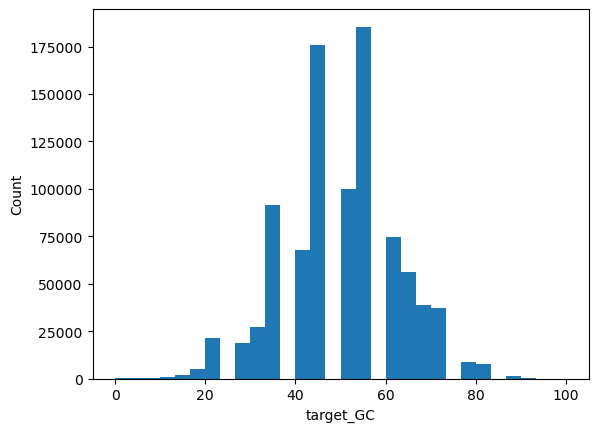

In [23]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trbc2
	ENSMUST00000103299.3: 555 / 663 probes passed the filter 40 < target_GC <  70.
Trdc
	ENSMUST00000196323.2: 2699 / 3836 probes passed the filter 40 < target_GC <  70.
Trac
	ENSMUST00000198398.5: 660 / 906 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103740.2: 325 / 384 probes passed the filter 40 < target_GC <  70.
Ighd
	ENSMUST00000194162.6: 1282 / 1777 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192250.2: 600 / 773 probes passed the filter 40 < target_GC <  70.
Iglc2
	ENSMUST00000198182.2: 360 / 429 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103749.3: 484 / 577 probes passed the filter 40 < target_GC <  70.
Klhl14
	ENSMUST00000122333.2: 2619 / 4394 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000049105.11: 2366 / 3989 probes passed the filter 40 < target_GC <  70.
Tmem252
	ENSMUST00000057243.6: 3257 / 5005 probes passed the filter 40 < target_GC <  70.
Dab2
	ENSMUST00000078019.13: 2085 / 3764 probes passed the filter 4

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000126417.3: 918 / 1466 probes passed the filter 40 < target_GC <  70.
Cyp2j5
	ENSMUST00000030299.8: 1237 / 2316 probes passed the filter 40 < target_GC <  70.
Enpp1
	ENSMUST00000105520.8: 3933 / 6748 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135846.2: 1774 / 2692 probes passed the filter 40 < target_GC <  70.
Ptpro
	ENSMUST00000167679.8: 3713 / 5067 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000077115.13: 3706 / 5020 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000167002.4: 1943 / 2738 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203914.2: 1885 / 2638 probes passed the filter 40 < target_GC <  70.
Ms4a1
	ENSMUST00000169159.3: 1402 / 3046 probes passed the filter 40 < target_GC <  70.
Ms4a7
	ENSMUST00000025574.11: 840 / 1547 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000067532.11: 756 / 1305 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000056035.9: 575 / 853 probes passed the filter 40 < targ

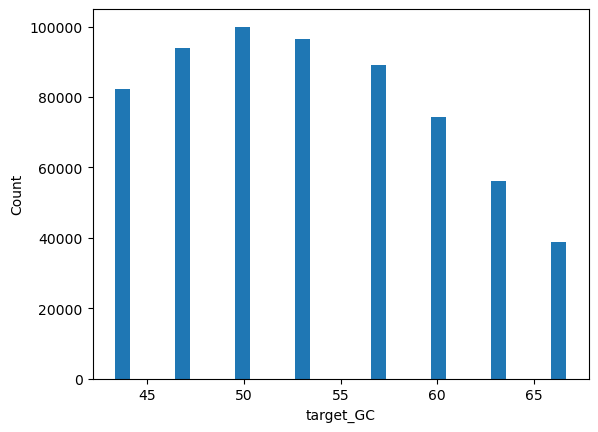

In [24]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

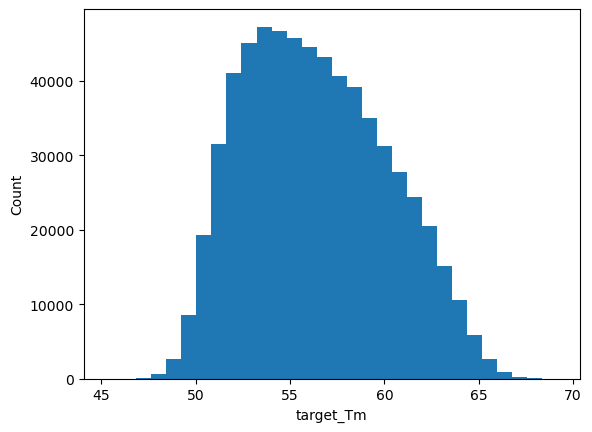

In [25]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trbc2
	ENSMUST00000103299.3: 548 / 555 probes passed the filter 50 < target_Tm <  65.
Trdc
	ENSMUST00000196323.2: 2548 / 2699 probes passed the filter 50 < target_Tm <  65.
Trac
	ENSMUST00000198398.5: 653 / 660 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103740.2: 321 / 325 probes passed the filter 50 < target_Tm <  65.
Ighd
	ENSMUST00000194162.6: 1230 / 1282 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192250.2: 589 / 600 probes passed the filter 50 < target_Tm <  65.
Iglc2
	ENSMUST00000198182.2: 357 / 360 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103749.3: 474 / 484 probes passed the filter 50 < target_Tm <  65.
Klhl14
	ENSMUST00000122333.2: 2572 / 2619 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000049105.11: 2327 / 2366 probes passed the filter 50 < target_Tm <  65.
Tmem252
	ENSMUST00000057243.6: 3175 / 3257 probes passed the filter 50 < target_Tm <  65.
Dab2
	ENSMUST00000078019.13: 2027 / 2085 probes passed the filter 5

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000121916.8: 593 / 602 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000034586.9: 416 / 423 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000118649.8: 400 / 404 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000145672.2: 266 / 267 probes passed the filter 50 < target_Tm <  65.
Apoa5
	ENSMUST00000121598.8: 2177 / 2201 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000214202.2: 321 / 324 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000215458.2: 284 / 286 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000215187.2: 393 / 393 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000213878.2: 586 / 588 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000034584.4: 1986 / 2003 probes passed the filter 50 < target_Tm <  65.
Cd28
	ENSMUST00000027165.3: 1869 / 2013 probes passed the filter 50 < target_Tm <  65.
Mcpt8
	ENSMUST00000015594.9: 612 / 617 probes passed the filter 50 < target_Tm <  65.
Gzmb
	ENSMUST0000

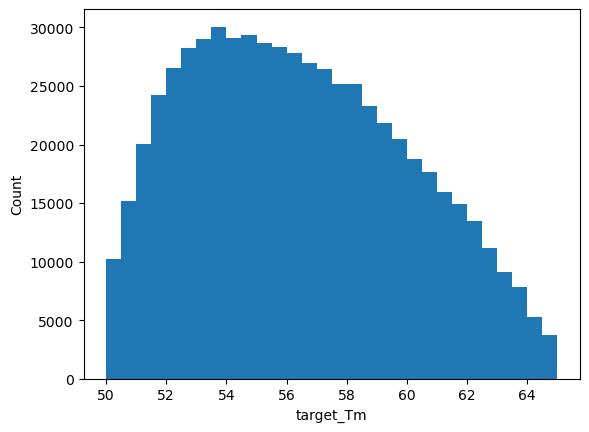

In [26]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [27]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [28]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Mat1a.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Fxyd3.
Construct a OTTable using 11/11 transcripts with FPKM > 0.
Generate OTTable for gene Pglyrp1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Col5a2.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ankrd1.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Nes.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Fgfbp1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ibsp.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cxcl14.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Cyp11a1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ptprb.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Gen

Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene C1qc.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Fasl.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Cd79a.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Enpp1.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Klrb1c.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ccr9.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Ms4a2.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Plcb1.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene C1qa.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Mrgpra2b.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Tppp3.
Construct 

In [29]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116912/116912 transcripts with FPKM > 0.
Processed 10000/116912 sequences.
Processed 20000/116912 sequences.
Processed 30000/116912 sequences.
Processed 40000/116912 sequences.
Processed 50000/116912 sequences.
Processed 60000/116912 sequences.
Processed 70000/116912 sequences.
Processed 80000/116912 sequences.
Processed 90000/116912 sequences.
Processed 100000/116912 sequences.
Processed 110000/116912 sequences.


In [30]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/146 genes.
Calculate OTs for 1/146 genes.
Calculate OTs for 2/146 genes.
Calculate OTs for 3/146 genes.
Calculate OTs for 4/146 genes.
Calculate OTs for 5/146 genes.
Calculate OTs for 6/146 genes.
Calculate OTs for 7/146 genes.
Calculate OTs for 8/146 genes.
Calculate OTs for 9/146 genes.
Calculate OTs for 10/146 genes.
Calculate OTs for 11/146 genes.
Calculate OTs for 12/146 genes.
Calculate OTs for 13/146 genes.
Calculate OTs for 14/146 genes.
Calculate OTs for 15/146 genes.
Calculate OTs for 16/146 genes.
Calculate OTs for 17/146 genes.
Calculate OTs for 18/146 genes.
Calculate OTs for 19/146 genes.
Calculate OTs for 20/146 genes.
Calculate OTs for 21/146 genes.
Calculate OTs for 22/146 genes.
Calculate OTs for 23/146 genes.
Calculate OTs for 24/146 genes.
Calculate OTs for 25/146 genes.
Calculate OTs for 26/146 genes.
Calculate OTs for 27/146 genes.
Calculate OTs for 28/146 genes.
Calculate OTs for 29/146 genes.
Calculate OTs for 30/146 genes.
Calculate OTs for 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000025718.10: 1207 / 1207 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Robo4
	ENSMUST00000214185.3: 4074 / 4074 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115048.10: 2912 / 2912 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115046.9: 3357 / 3357 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000102895.7: 2780 / 2780 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000239486.2: 3177 / 3177 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cd4
	ENSMUST00000024044.7: 2634 / 2634 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Foxp3
	ENSMUST00000234896.2: 415 / 415 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000234363.2: 1811 / 1824 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000235116.2: 1285 / 1298 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115739.9: 3224 / 3237 probes passed the filter -inf < target_

	ENSMUST00000031320.8: 387 / 387 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000202625.2: 318 / 318 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cxcl3
	ENSMUST00000031326.10: 391 / 391 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ccr4
	ENSMUST00000054414.5: 1903 / 1903 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000215425.2: 1211 / 1211 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000215959.2: 216 / 216 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Eomes
	ENSMUST00000111763.8: 1666 / 1666 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000035020.15: 1885 / 1885 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150633.2: 784 / 784 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Hoxa10
	ENSMUST00000125581.2: 1128 / 1128 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000121043.2: 995 / 995 probes passed the filter -inf < target_OT

### Off-targets to transcriptome

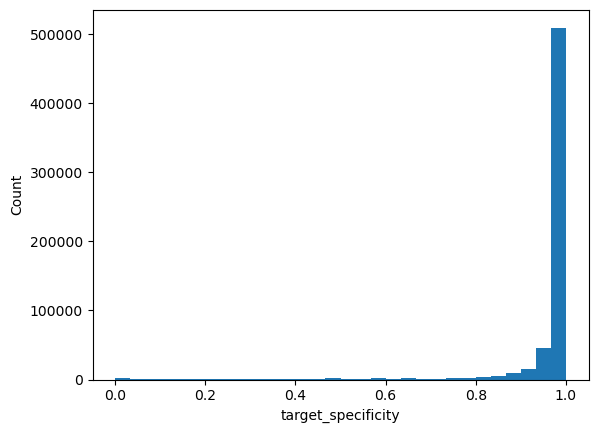

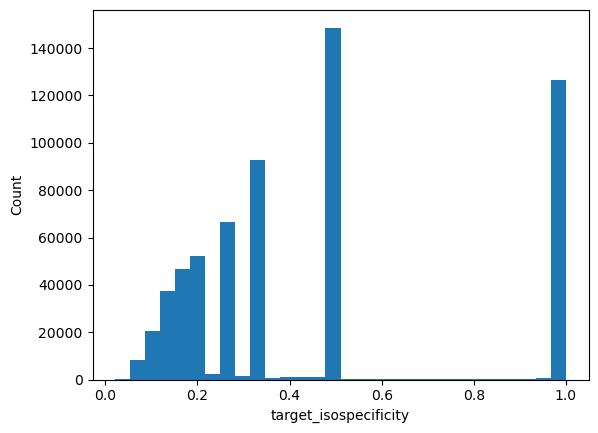

In [31]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [32]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

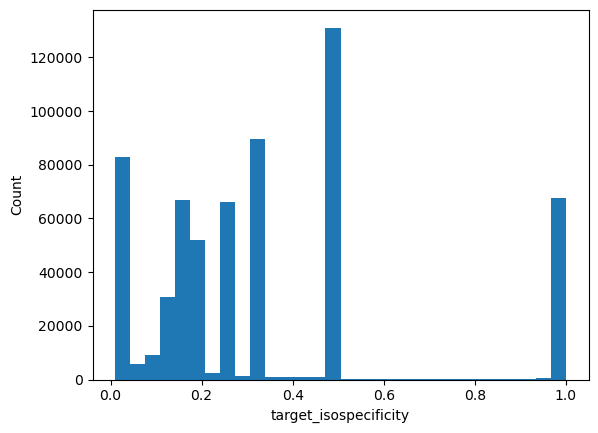

In [33]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trbc2
	ENSMUST00000103299.3: 154 / 548 probes passed the filter 0.99 < target_specificity <  inf.
Trdc
	ENSMUST00000196323.2: 2097 / 2486 probes passed the filter 0.99 < target_specificity <  inf.
Trac
	ENSMUST00000198398.5: 536 / 653 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103740.2: 263 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Ighd
	ENSMUST00000194162.6: 946 / 1230 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000192250.2: 495 / 589 probes passed the filter 0.99 < target_specificity <  inf.
Iglc2
	ENSMUST00000198182.2: 104 / 357 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103749.3: 167 / 474 probes passed the filter 0.99 < target_specificity <  inf.
Klhl14
	ENSMUST00000122333.2: 2032 / 2572 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000049105.11: 1863 / 2327 probes passed the filter 0.99 < target_specificity <  inf.
Tmem252
	ENSMUST00000057243.6: 2293 / 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000199481.2: 1296 / 1609 probes passed the filter 0.99 < target_specificity <  inf.
Gjb1
	ENSMUST00000119080.8: 837 / 1149 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000052130.14: 904 / 1201 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000119190.2: 892 / 1204 probes passed the filter 0.99 < target_specificity <  inf.
Cr2
	ENSMUST00000195120.6: 2409 / 3040 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000193436.2: 88 / 122 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000193801.2: 96 / 136 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000210219.2: 2060 / 2465 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000082321.9: 2403 / 3034 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000043104.9: 465 / 560 probes passed the filter 0.99 < target_specificity <  inf.
Col6a6
	ENSMUST00000098441.10: 5459 / 7186 probes passed the 

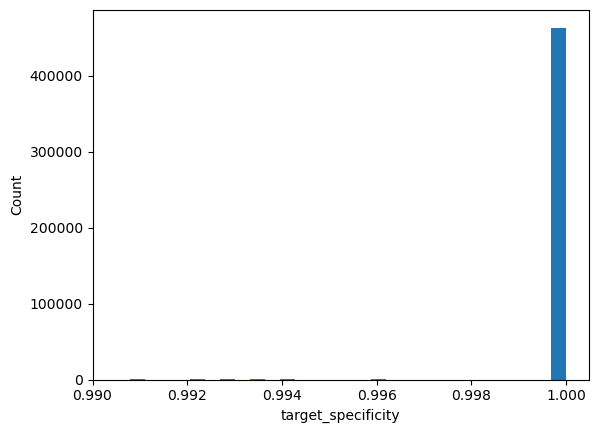

In [34]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

## save probe_dict

In [35]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/2023_10_18_full_probe_isoforms.pkl


## Restart here

In [36]:
import pickle
full_probe_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/2023_10_18_full_probe_isoforms.pkl'
if 'probe_dict' not in locals():
    probe_dict = pickle.load(open(full_probe_filename, 'rb'))
replace_dict = np.load(os.path.join(library_folder, 'replace_dict.npy'), allow_pickle=True).item()

## Select probe isoform

In [37]:
## Select transcript based on length / number of possible probes:
largest_probe_th = 800
median_probe_th = 400


for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Trac
Iglc2
Cyp2c29
Akr1c6
Ms4a2
Cd3g
Apoc3
S100a4
Pf4
Fcer1a
Mrgpra2b


In [38]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


[154] [154]
ENSMUST00000103299.3 154
[2097] [2097]
ENSMUST00000196323.2 2097
[536, 263] [263, 263]
ENSMUST00000198398.5 536
[946, 495] [431, 431]
ENSMUST00000194162.6 946
[104, 167] [104, 104]
ENSMUST00000103749.3 167
[2032, 1863] [1863, 1863]
ENSMUST00000122333.2 2032
[2293] [2293]
ENSMUST00000057243.6 2293
[1609, 171, 472, 2101, 1310, 1270, 677, 219, 398, 1127, 1989] [1609, 156, 457, 2028, 1310, 1265, 532, 172, 227, 1127, 1989]
ENSMUST00000080880.12 2101
[331, 1136] [188, 896]
ENSMUST00000042868.6 1136
[1010, 1510, 971, 282] [917, 1402, 882, 277]
ENSMUST00000056097.11 1510
[426, 314, 335, 447, 653, 625, 511, 629, 1231] [426, 314, 335, 447, 653, 625, 511, 629, 400]
ENSMUST00000114611.10 653
[1475, 138, 1603] [1475, 138, 1538]
ENSMUST00000015197.9 1603
[524] [524]
ENSMUST00000068592.5 524
[586] [586]
ENSMUST00000060484.9 586
[1162] [1162]
ENSMUST00000023336.10 1162
[784] [784]
ENSMUST00000065248.9 784
[172] [172]
ENSMUST00000065666.6 172
[1528, 1443] [1474, 1429]
ENSMUST00000066747.14 

In [39]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trbc2
	ENSMUST00000103299.3	154
Trdc
	ENSMUST00000196323.2	2097
Trac
	ENSMUST00000198398.5	536
Ighd
	ENSMUST00000194162.6	946
Iglc2
	ENSMUST00000103749.3	167
Klhl14
	ENSMUST00000122333.2	2032
Tmem252
	ENSMUST00000057243.6	2293
Dab2
	ENSMUST00000080880.12	2101
Camk4
	ENSMUST00000042868.6	1136
Themis
	ENSMUST00000056097.11	1510
Cd200r3
	ENSMUST00000114611.10	653
Gata2
	ENSMUST00000015197.9	1603
Ifng
	ENSMUST00000068592.5	524
Clec4a1
	ENSMUST00000060484.9	586
Cd96
	ENSMUST00000023336.10	1162
Cd8b1
	ENSMUST00000065248.9	784
Retnlg
	ENSMUST00000065666.6	172
Cd8a
	ENSMUST00000066747.14	1528
Clec14a
	ENSMUST00000062254.4	2030
Pou2af1
	ENSMUST00000034554.9	1166
Col5a2
	ENSMUST00000086430.5	2959
Wnt7b
	ENSMUST00000109424.4	1786
Ibsp
	ENSMUST00000031246.9	847
Htr1b
	ENSMUST00000183482.2	2039
Prex2
	ENSMUST00000027056.12	3748
Ankrd1
	ENSMUST00000237142.2	1157
Robo4
	ENSMUST00000214185.3	3039
Cd4
	ENSMUST00000024044.7	1941
Foxp3
	ENSMUST00000115739.9	2675
Cyp2c29
	ENSMUST0

In [40]:
sequencing_data_folder = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X'
manual_kept_genes = pd.read_csv(os.path.join(sequencing_data_folder, 'merfish_4T1_genes_removed.csv'))

In [41]:
kept_gene_list = []
removed_gene_list = []
for _gene, _t_2_pbs in sel_pb_dict.items():
    _pbs = list(_t_2_pbs.values())[0]
    if len(_pbs) < 600 and _gene not in list(manual_kept_genes['gene']):
        print(_gene)
        removed_gene_list.append(_gene)
    else:
        kept_gene_list.append(_gene)

Trbc2
Trac
Iglc2
Clec4a1
Cyp2c29
Cyp2c39
Krt14
Akr1c6
Pglyrp1
Ms4a6c
Ces1b
Krt18
Stfa2l1
Apoc3
Mcpt8
G0s2
Vpreb3
S100a4
Wfdc21
Pf4
Mrgpra2b
Ccl12


In [42]:
len(kept_gene_list)

124

In [43]:
target_gene_mean_exp_df.loc[np.array(kept_gene_list)]


,Neutrophil,T_NK,B_cell,Macrophage,Myeloid,Malignant,Basophil,Endothelial,Hepatocyte
Unnamed: 0,,,,,,,,,
Trdc,0.001020,0.111697,0.005766,0.002744,0.000748,0.003075,0.009648,0.015243,0.000000
Ighd,0.003003,0.003496,0.899805,0.006653,0.006015,0.000000,0.023902,0.011424,0.014535
Klhl14,0.001242,0.001061,0.349993,0.002676,0.002129,0.000000,0.006115,0.000000,0.000000
Tmem252,0.000165,0.000424,0.000000,0.000000,0.000487,0.000000,0.000000,0.359993,0.000000
Dab2,0.029525,0.007403,0.006427,1.238839,0.084142,0.298846,0.020188,0.692550,0.016330
...,...,...,...,...,...,...,...,...,...
Fermt1,0.000425,0.000304,0.000000,0.000866,0.000000,0.304130,0.000000,0.006417,0.013245
Plcb1,0.059047,0.023600,0.033370,0.575547,1.587539,0.032970,0.232185,1.204671,0.066463
Cd300e,0.003806,0.000803,0.000268,0.004639,0.014657,0.000560,0.000000,0.010909,0.000000


In [44]:
replace_dict

{'Tcrg-C1': 'Trgc1',
 'Tcrg-C2': 'Trgc2',
 'Tcrg-C4': 'Trgc4',
 'Sept1': 'Septin1',
 'H2afy': 'Macroh2a2',
 'Qk': 'Qki',
 'Hist1h1b': 'H1f5',
 'Fam129b': 'Niban2',
 'Sept3': 'Septin3',
 'Hist1h2ab': 'H2ac4',
 'Il1f9': 'Il36g',
 'Cd163l1': 'Scart1',
 'Hist1h2af': 'H2ac10',
 'Fam71f2': 'Garin1a',
 'Hist1h3c': 'H3c3',
 'Ero1l': 'Ero1a',
 'Fam129c': 'Niban3',
 'Gm14548': 'Pira12',
 'Ptprg': 'PTPRG'}

In [45]:
# given these genes, re-calculate expression
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
target_gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename)
target_gene_umi_frac_df = target_gene_umi_frac_df.set_index(target_gene_umi_frac_df.columns[0])
target_gene_umi_frac_df.rename(index=replace_dict, inplace=True)
kept_gene_umi_frac_df = target_gene_umi_frac_df.loc[np.array(kept_gene_list)]


In [46]:
figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

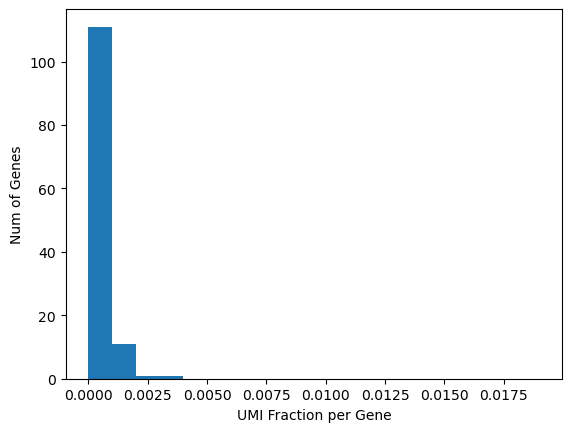

In [47]:
plt.figure()
plt.hist(np.sum(kept_gene_umi_frac_df, 1), bins=np.arange(0, 0.02, 0.001))
plt.xlabel("UMI Fraction per Gene")
plt.ylabel("Num of Genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_UMI_fraction_histogram.png"), 
            transparent=True)
plt.show()

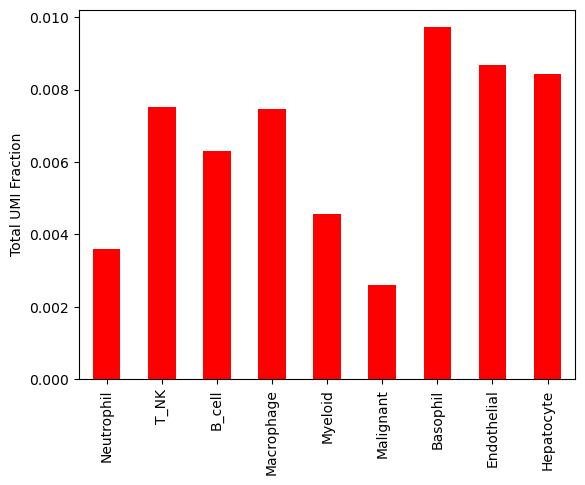

In [48]:
plt.figure()
np.sum(kept_gene_umi_frac_df, 0).plot.bar(color='red')
plt.ylabel("Total UMI Fraction")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_Total_UMI_fraction.png"), 
            transparent=True)
plt.show()

In [49]:
len(kept_gene_list)

124

## determine marker gene group

In [50]:
group_2_genes = {_g:[] for _g in target_gene_mean_exp_df.columns}
for _gene in kept_gene_list:
    _exp = target_gene_mean_exp_df.loc[_gene]
    _group = _exp.index[np.argmax(_exp)]
    group_2_genes[_group].append(_gene)
marker_gene_num_df = pd.Series({_group: len(_genes) for _group, _genes in group_2_genes.items()})

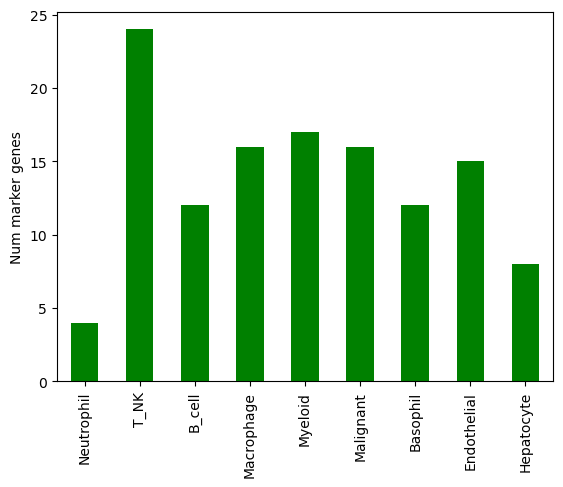

In [51]:
plt.figure()
marker_gene_num_df.plot.bar(color='green')
plt.ylabel("Num marker genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_marker_gene_number.png"), 
            transparent=True)
plt.show()

In [52]:
gene_2_group = {}
for _group, _genes in group_2_genes.items():
    for _g in _genes:
        gene_2_group[_g] = _group

In [53]:
# candidate probes
candidate_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_candidate_probe.pkl")
print(candidate_probe_filename)
pickle.dump(sel_pb_dict, open(candidate_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/2023_10_18_candidate_probe.pkl


In [54]:
# load probe_dict
probe_dict = pickle.load(open(full_probe_filename, 'rb'))

In [55]:
# delete
del(probe_dict)

In [56]:
# Save the list of genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')

kept_gene_info = ({'Name':kept_gene_list,
                   'Transcript': [list(sel_pb_dict[_gene].keys())[0] for _gene in kept_gene_list],
                   'Num_Candidate_Probes': [len(list(sel_pb_dict[_g].values())[0]) for _g in kept_gene_list],
                  'Group': [gene_2_group[_g] for _g in kept_gene_list],
                  }
                 )
                    
kept_gene_info = pd.DataFrame(kept_gene_info).set_index("Name")
# add info
kept_gene_info = pd.concat([kept_gene_info, target_gene_mean_exp_df.loc[kept_gene_list]], axis=1)
# save
kept_gene_info.to_csv(kept_gene_filename, index=1)
print(kept_gene_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/kept_gene_info.csv


In [57]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophil,T_NK,B_cell,Macrophage,Myeloid,Malignant,Basophil,Endothelial,Hepatocyte
Trdc,ENSMUST00000196323.2,2097,T_NK,0.001020,0.111697,0.005766,0.002744,0.000748,0.003075,0.009648,0.015243,0.000000
Ighd,ENSMUST00000194162.6,946,B_cell,0.003003,0.003496,0.899805,0.006653,0.006015,0.000000,0.023902,0.011424,0.014535
Klhl14,ENSMUST00000122333.2,2032,B_cell,0.001242,0.001061,0.349993,0.002676,0.002129,0.000000,0.006115,0.000000,0.000000
Tmem252,ENSMUST00000057243.6,2293,Endothelial,0.000165,0.000424,0.000000,0.000000,0.000487,0.000000,0.000000,0.359993,0.000000
Dab2,ENSMUST00000080880.12,2101,Macrophage,0.029525,0.007403,0.006427,1.238839,0.084142,0.298846,0.020188,0.692550,0.016330
...,...,...,...,...,...,...,...,...,...,...,...,...
Fermt1,ENSMUST00000038280.5,2820,Malignant,0.000425,0.000304,0.000000,0.000866,0.000000,0.304130,0.000000,0.006417,0.013245
Plcb1,ENSMUST00000131552.5,2795,Myeloid,0.059047,0.023600,0.033370,0.575547,1.587539,0.032970,0.232185,1.204671,0.066463
Cd300e,ENSMUST00000062787.9,1188,Myeloid,0.003806,0.000803,0.000268,0.004639,0.014657,0.000560,0.000000,0.010909,0.000000
Azgp1,ENSMUST00000035390.7,825,Hepatocyte,0.000421,0.000861,0.000423,0.000000,0.000660,0.000000,0.000000,0.000000,0.959204


In [59]:
# save removed genes
removed_gene_filename = os.path.join(library_folder, 'removed_genes.csv')
print(removed_gene_filename)
pd.DataFrame({'Name':removed_gene_list}).to_csv(removed_gene_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/removed_genes.csv


# PAUSE HERE, go to jupyter-3 to design codebook